In [1]:
import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

import testzd as zd

# Investigate whether or not a strategy is zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. This result showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

The question arises:

**Given a strategy $p$, is it a zero determinant strategy?**

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Mx$$

Where:

$$
M = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\begin{aligned}
\alpha s_x - P &= 2(s_y - P)\\
\alpha s_x - 2s_y + P&=0\\
\end{aligned}
$$

Let us solve $Mx=\tilde p$

In [2]:
R, S, T, P = sym.S(3), sym.S(0), sym.S(5), sym.S(1)

tilde_p = sym.Matrix([sym.S(8) / 9 - 1, sym.S(1) / 2 - 1, sym.S(1) / 3, sym.S(0)])
M = sym.Matrix([[R, R, 1], 
                [S, T, 1],
                [T, S, 1], 
                [P, P, 1]])

In [3]:
system = (M, tilde_p)
symbols = sym.symbols("alpha, beta, gamma")
sym.linsolve(system, symbols)

{(1/18, -1/9, 1/18)}

This gives $\alpha = 1 / 18$, $\beta = -1/9$ and $\gamma = 1 / 18$ which ensures:

$$
1/18 s_x -1/9 s_y + 1/18 = 0
$$

multiplying this by 18 gives:


$$
s_x -2 s_y + 1 = 0
$$

which is the relationship described above.

Note that in practice, a vector $p$ might not be defined exactly: indeed it could be measured from observation. Thus: $p\notin\mathbb{Q}^{4\times 1}$ but $p\in\mathbb{R}^{4\times 1}$. As such that linear equations may no longer have exact solutions and/or indeed have no solutions at all as $M$ is not a square matrix.

A practical approach to checking if a strategy is ZD or not makes use of the continuity of the determinant of a matrix. As the calculation of a matrix is a linear combination of its elements, a matrix with determinant "almost" zero is close to a matrix that has zero determinant.

## $\epsilon$-ZD strategies

We define:

$$\bar M ^{(i)} = M_{(i; i)}$$

The matrix $\bar M ^{(i)}\in\mathbb{R}^{3\times 3}$ is the matrix $M$ with the $i$th row removed.

Similarly:

$$\bar p^{(i)} = \tilde p_{(i)}$$

The vector $\bar p^{(i)}\in\mathbb{R}^{3\times 1}$ is the vector $\tilde p$ with the $i$th element removed.

Solving 

$$\bar M ^{(i)} x^{(i)} = \bar p^{(i)}$$ 

gives $\bar x^{(i)}$ and if $\min _{1\leq i\leq 4}|M_i\bar x^{(i)} - \tilde p_i| < \epsilon$ for some $\epsilon > 0$ then $p$ is $\epsilon$-ZD.

Thus if $\epsilon$-ZD are strategies for which values of $\alpha, \beta, \gamma$ can be found that make the strategy "close" to being a ZD strategy.

Let us confirm that `Extort-2` is $\epsilon$-ZD with $\epsilon=10 ^ {-7}$:

In [4]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_epsilon_ZD(p)

True

Note that the following vector is not:

$$p = (8 / 9, 1, 1 / 3, 0)$$

In [5]:
zd.is_epsilon_ZD(np.array([8 / 9, 1, 1 / 3, 0]))

False

## Empirical observation

Let us consider the latest tournament of the Axelrod project:

In [15]:
df_standard = pd.read_csv("http://axelrod-tournament.readthedocs.io/en/latest/_downloads/std_summary.csv")
df_noisy = pd.read_csv("http://axelrod-tournament.readthedocs.io/en/latest/_downloads/noisy_summary.csv")
df_probend = pd.read_csv("http://axelrod-tournament.readthedocs.io/en/latest/_downloads/probend_summary.csv")

In [16]:
columns = ["CC_to_C_rate", "CD_to_C_rate", "DC_to_C_rate", "DD_to_C_rate"]
epsilons = 10 ** np.linspace(-1, -4, 100)
counts = {"standard": [], "noisy": [], "probend": []}
min_ranks = {"standard": [], "noisy": [], "probend": []}
dfs = {"standard": df_standard, "noisy": df_noisy, "probend": df_probend}

for key, df in dfs.items():
    for epsilon in epsilons:
        played_ZD = []
        
        for _, row in df.iterrows():
            p = np.array(row[columns])
            played_ZD.append(zd.is_epsilon_ZD(p, epsilon=epsilon))
            
        counts[key].append(sum(played_ZD))
        zd_df = df[played_ZD]
        
        min_ranks[key].append(zd_df["Rank"].min())

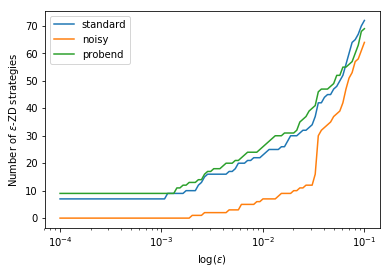

In [17]:
fig = plt.figure()
ax = plt.gca()

for key, _ in dfs.items():
    ax.plot(epsilons, counts[key], label=key);
ax.set_xscale('log')
plt.legend()
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Number of $\epsilon$-ZD strategies")
plt.show();

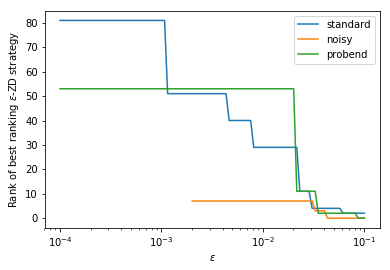

In [18]:
fig = plt.figure()
ax = plt.gca()

for key, _ in dfs.items():
    ax.plot(epsilons, min_ranks[key], label=key);
ax.set_xscale('log')
plt.legend()
plt.xlabel("$\epsilon$")
plt.ylabel("Rank of best ranking $\epsilon$-ZD strategy")
plt.show();

## Evaluate the Press and Dyson tournament

The definition of an $\epsilon$-ZD strategies also allows for a measure of how close to a ZD strategy does a strategy actually play. A linear search over $\mathbb{R}_{\geq 0}$ finding the lowest possible value of $\epsilon$ for which a given strategy is $\epsilon$-ZD gives this.

In [2]:
import axelrod as axl
C, D = axl.Action.C, axl.Action.D

stewart_and_plotkin_players = [axl.Cooperator(), 
                               axl.Defector(), 
                               axl.ZDExtort2(), 
                               axl.HardGoByMajority(), 
                               axl.Joss(),
                               axl.HardTitForTat(),
                               axl.HardTitFor2Tats(),
                               axl.TitForTat(),
                               axl.Grudger(),
                               axl.GTFT(),
                               axl.TitFor2Tats(),
                               axl.WinStayLoseShift(),
                               axl.Random(),
                               axl.ZDGTFT2()]
std_tournament = axl.Tournament(players=stewart_and_plotkin_players, turns=500, repetitions=20)
std_results = std_tournament.play()
noisy_tournament = axl.Tournament(players=stewart_and_plotkin_players, turns=500, noise=0.05, repetitions=20)
noisy_results = noisy_tournament.play()
probend_tournament = axl.Tournament(players=stewart_and_plotkin_players, prob_end=0.05, repetitions=20)
probend_results = probend_tournament.play()

Analysing: 100%|██████████| 25/25 [00:00<00:00, 98.70it/s]


In [3]:
import testzd.data_collection as dc

In [4]:
epsilons = 10 ** np.linspace(-1, -4, 100)
df = dc.analyse_tournament_behaviour(std_results, epsilons=epsilons)

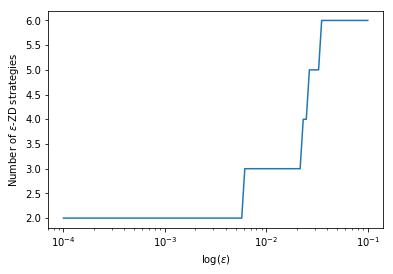

In [8]:
fig = plt.figure()
ax = plt.gca()

ax.plot(df["epsilon"], df["counts"]);
ax.set_xscale('log')
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Number of $\epsilon$-ZD strategies")
plt.show();

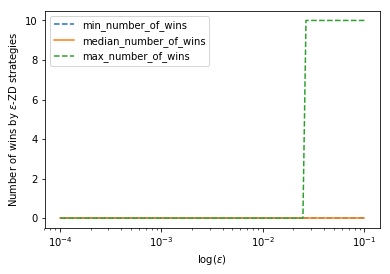

In [12]:
fig = plt.figure()
ax = plt.gca()

ax.plot(df["epsilon"], df["min_number_of_wins"], "--")
ax.plot(df["epsilon"], df["median_number_of_wins"])
ax.plot(df["epsilon"], df["max_number_of_wins"], "--")
ax.set_xscale('log')
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Number of wins by $\epsilon$-ZD strategies")
plt.legend()
plt.show();

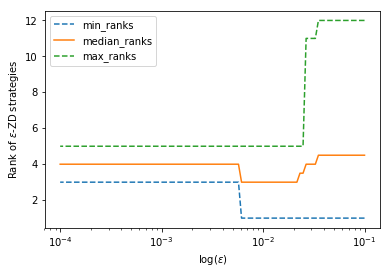

In [13]:
fig = plt.figure()
ax = plt.gca()

ax.plot(df["epsilon"], df["min_ranks"], "--")
ax.plot(df["epsilon"], df["median_ranks"])
ax.plot(df["epsilon"], df["max_ranks"], "--")
ax.set_xscale('log')
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Rank of $\epsilon$-ZD strategies")
plt.legend()
plt.show();

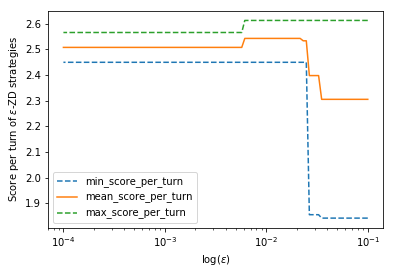

In [15]:
fig = plt.figure()
ax = plt.gca()

ax.plot(df["epsilon"], df["min_score_per_turn"], "--")
ax.plot(df["epsilon"], df["mean_score_per_turn"])
ax.plot(df["epsilon"], df["max_score_per_turn"], "--")
ax.set_xscale('log')
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Score per turn of $\epsilon$-ZD strategies")
plt.legend()
plt.show();

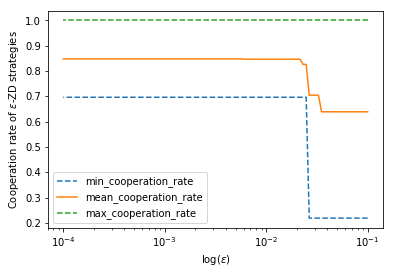

In [17]:
fig = plt.figure()
ax = plt.gca()

ax.plot(df["epsilon"], df["min_cooperation_rate"], "--")
ax.plot(df["epsilon"], df["mean_cooperation_rate"])
ax.plot(df["epsilon"], df["max_cooperation_rate"], "--")
ax.set_xscale('log')
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("Cooperation rate of $\epsilon$-ZD strategies")
plt.legend()
plt.show();

In [18]:
std_lowest_epsilon = dc.obtain_pairwise_epsilons(std_results)
noisy_lowest_epsilon = dc.obtain_pairwise_epsilons(noisy_results)
probend_lowest_epsilon = dc.obtain_pairwise_epsilons(probend_results)

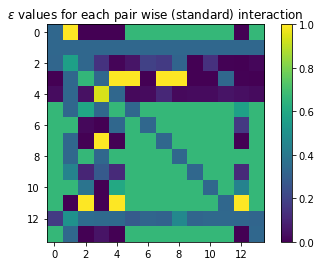

In [19]:
plt.imshow(std_lowest_epsilon)
plt.title("$\epsilon$ values for each pair wise (standard) interaction")
plt.colorbar();

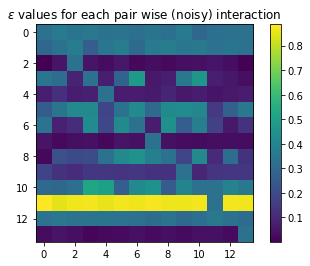

In [20]:
plt.imshow(noisy_lowest_epsilon)
plt.title("$\epsilon$ values for each pair wise (noisy) interaction")
plt.colorbar();

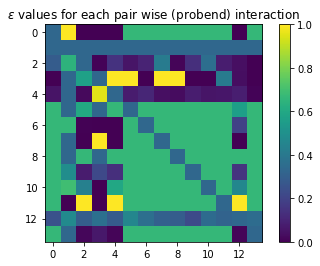

In [21]:
plt.imshow(probend_lowest_epsilon)
plt.title("$\epsilon$ values for each pair wise (probend) interaction")
plt.colorbar();

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.